In [ ]:
from pandas import read_csv
import pandas as pd
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')

len(data)


10000

In [ ]:
data.value_counts(['Credit_Score'])

,count
Credit_Score,
Standard,5317
Poor,2900
Good,1783


In [ ]:
info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     10000 non-null  object 
 1   Age                       10000 non-null  int64  
 2   Occupation                10000 non-null  object 
 3   Annual_Income             10000 non-null  float64
 4   Monthly_Inhand_Salary     10000 non-null  float64
 5   Num_Bank_Accounts         10000 non-null  int64  
 6   Num_Credit_Card           10000 non-null  int64  
 7   Interest_Rate             10000 non-null  float64
 8   Num_of_Loan               10000 non-null  int64  
 9   Type_of_Loan              10000 non-null  object 
 10  Delay_from_due_date       10000 non-null  float64
 11  Num_of_Delayed_Payment    10000 non-null  int64  
 12  Changed_Credit_Limit      10000 non-null  float64
 13  Num_Credit_Inquiries      10000 non-null  int64  
 14  Credit_

##RANDOM FOREST WITH BALANCING - ALL FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Undersampling to match 'Poor' class size
undersample = RandomUnderSampler(sampling_strategy={'Standard': 2046}, random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)
print("After Undersampling:", Counter(y_train_resampled))

# Apply SMOTE to balance 'Good' class to the size of 'Poor'
smote = SMOTE(sampling_strategy={'Good': 2046}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)
print("After SMOTE:", Counter(y_train_resampled))

# Hyperparameter tuning using GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Random Forest with the best parameters
model = RandomForestClassifier(random_state=42, **best_params)
model.fit(X_train_resampled, y_train_resampled)

# Predictions and Evaluation
y_pred = model.predict(X_test)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy, Recall, Precision, Specificity
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each class
def calculate_specificity(class_idx):
    # True Negatives for the current class
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    # False Positives for the current class
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    # Specificity = TN / (TN + FP)
    return tn / (tn + fp)

specificity_poor = calculate_specificity(0)  # Poor class (index 0)
specificity_standard = calculate_specificity(1)  # Standard class (index 1)
specificity_good = calculate_specificity(2)  # Good class (index 2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity for Poor: {specificity_poor:.4f}")
print(f"Specificity for Standard: {specificity_standard:.4f}")
print(f"Specificity for Good: {specificity_good:.4f}")

After Undersampling: Counter({'Poor': 2046, 'Standard': 2046, 'Good': 1231})
After SMOTE: Counter({'Good': 2046, 'Poor': 2046, 'Standard': 2046})
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.49      0.76      0.60       552
    Standard       0.62      0.73      0.67       854
        Good       0.80      0.58      0.67      1594

    accuracy                           0.66      3000
   macro avg       0.64      0.69      0.65      3000
weighted avg       0.70      0.66      0.66      3000

Confusion Matrix:
[[417  17 118]
 [121 626 107]
 [305 363 926]]
Accuracy: 0.6563
Recall: 0.6563
Precision: 0.6956
Specificity for Poor: 0.8260
Specificity for Standard: 0.8229
Specificity for Good: 0.8400


##RANDOM FOREST WITHOUT BALANCING - ALL FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
import pandas as pd

# Load data
data2 = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X2 = data2.drop(columns=['Credit_Score'])
y2 = data2['Credit_Score']

# Encode categorical features
X_encoded2 = pd.get_dummies(X2, drop_first=True)

# Split into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_encoded2, y2, test_size=0.3, random_state=42)

# Hyperparameter tuning using GridSearchCV for Random Forest
param_grid2 = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini']
}

grid_search2 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid2, cv=5, scoring='accuracy', n_jobs=-1)
grid_search2.fit(X_train2, y_train2)

best_params2 = grid_search2.best_params_
print(f"Best Hyperparameters: {best_params2}")

# Train Random Forest with the best parameters
model2 = RandomForestClassifier(random_state=42, **best_params2)
model2.fit(X_train2, y_train2)

# Predictions and Evaluation
y_pred2 = model2.predict(X_test2)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test2, y_pred2, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm2 = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:")
print(cm2)

# Accuracy, Recall, Precision, Specificity
accuracy2 = accuracy_score(y_test2, y_pred2)
recall2 = recall_score(y_test2, y_pred2, average='weighted')
precision2 = precision_score(y_test2, y_pred2, average='weighted')

# Calculate Specificity for each class
def calculate_specificity2(class_idx):
    # True Negatives for the current class
    tn2 = cm2.sum() - cm2[:, class_idx].sum() - cm2[class_idx, :].sum() + cm2[class_idx, class_idx]
    # False Positives for the current class
    fp2 = cm2[:, class_idx].sum() - cm2[class_idx, class_idx]
    # Specificity = TN / (TN + FP)
    return tn2 / (tn2 + fp2)

specificity_poor2 = calculate_specificity2(0)  # Poor class (index 0)
specificity_standard2 = calculate_specificity2(1)  # Standard class (index 1)
specificity_good2 = calculate_specificity2(2)  # Good class (index 2)

print(f"Accuracy: {accuracy2:.4f}")
print(f"Recall: {recall2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Specificity for Poor: {specificity_poor2:.4f}")
print(f"Specificity for Standard: {specificity_standard2:.4f}")
print(f"Specificity for Good: {specificity_good2:.4f}")


Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.59      0.49      0.53       552
    Standard       0.67      0.65      0.66       854
        Good       0.69      0.74      0.72      1594

    accuracy                           0.67      3000
   macro avg       0.65      0.63      0.64      3000
weighted avg       0.67      0.67      0.67      3000

Confusion Matrix:
[[ 271    9  272]
 [  46  557  251]
 [ 146  268 1180]]
Accuracy: 0.6693
Recall: 0.6693
Precision: 0.6660
Specificity for Poor: 0.9216
Specificity for Standard: 0.8709
Specificity for Good: 0.6280


##RANDOM FOREST WITH BALANCING - SELECTED FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

# Encode categorical features
X_encoded3 = pd.get_dummies(X, drop_first=True)

# Split into train and test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_encoded3, y, test_size=0.3, random_state=42)

# Check dataset distribution before sampling
print("Before Sampling:", Counter(y_train3))

# Undersampling to match 'Poor' class size
undersample3 = RandomUnderSampler(sampling_strategy={'Standard': 2046}, random_state=42)
X_train3_resampled, y_train3_resampled = undersample3.fit_resample(X_train3, y_train3)

# Apply SMOTE to balance 'Good' class to the size of 'Poor'
smote3 = SMOTE(sampling_strategy={'Good': 2046}, random_state=42)
X_train3_resampled, y_train3_resampled = smote3.fit_resample(X_train3_resampled, y_train3_resampled)

# Check dataset distribution after sampling
print("After Undersampling and SMOTE:", Counter(y_train3_resampled))

# Quick feature selection using feature importance
base_model = RandomForestClassifier(n_estimators=50, random_state=42)
base_model.fit(X_train3_resampled, y_train3_resampled)
feature_importances = base_model.feature_importances_
top_features_idx = np.argsort(feature_importances)[-10:]
top_10_features = X_train3_resampled.columns[top_features_idx]
print(f"Top 10 Features: {top_10_features}")

# Transform datasets to keep only top 10 features
X_train3_rfe = X_train3_resampled[top_10_features]
X_test3_rfe = X_test3[top_10_features]

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=4,
    verbose=2
)

random_search.fit(X_train3_rfe, y_train3_resampled)
best_params3 = random_search.best_params_
print(f"Best Hyperparameters: {best_params3}")

# Train Random Forest with the best parameters
model3 = RandomForestClassifier(random_state=42, **best_params3)
model3.fit(X_train3_rfe, y_train3_resampled)

# Predictions and Evaluation
y3_pred = model3.predict(X_test3_rfe)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test3, y3_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm3 = confusion_matrix(y_test3, y3_pred)
print("Confusion Matrix:")
print(cm3)

# Accuracy, Recall, Precision, Specificity
accuracy3 = accuracy_score(y_test3, y3_pred)
recall3 = recall_score(y_test3, y3_pred, average='weighted')
precision3 = precision_score(y_test3, y3_pred, average='weighted')

def calculate_specificity3(class_idx):
    tn = cm3.sum() - cm3[:, class_idx].sum() - cm3[class_idx, :].sum() + cm3[class_idx, class_idx]
    fp = cm3[:, class_idx].sum() - cm3[class_idx, class_idx]
    return tn / (tn + fp)

specificity_poor3 = calculate_specificity3(0)
specificity_standard3 = calculate_specificity3(1)
specificity_good3 = calculate_specificity3(2)

print(f"Accuracy: {accuracy3:.4f}")
print(f"Recall: {recall3:.4f}")
print(f"Precision: {precision3:.4f}")
print(f"Specificity for Poor: {specificity_poor3:.4f}")
print(f"Specificity for Standard: {specificity_standard3:.4f}")
print(f"Specificity for Good: {specificity_good3:.4f}")


Before Sampling: Counter({'Standard': 3723, 'Poor': 2046, 'Good': 1231})
After Undersampling and SMOTE: Counter({'Good': 2046, 'Poor': 2046, 'Standard': 2046})
Top 10 Features: Index(['Monthly_Balance', 'Num_Credit_Inquiries', 'Changed_Credit_Limit',
       'Num_Bank_Accounts', 'Num_of_Delayed_Payment', 'Num_Credit_Card',
       'Credit_Mix_Good', 'Delay_from_due_date', 'Interest_Rate',
       'Outstanding_Debt'],
      dtype='object')
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20, 'criterion': 'gini'}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.53      0.75      0.62       552
    Standard       0.64      0.75      0.69       854
        Good       0.80      0.61      0.69      1594

    accuracy                           0.68      3000
   macro avg       0.66      0.70      0.67      3000
weighted avg       0

##RANDOM FOREST WITHOUT BALANCING - SELECTED FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from collections import Counter
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

# Encode categorical features
X_encoded4 = pd.get_dummies(X, drop_first=True)

# Split into train and test
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_encoded4, y, test_size=0.3, random_state=42)

# Check dataset distribution before sampling
print("Dataset Distribution (Train):", Counter(y_train4))

# Quick feature selection using feature importance
base_model4 = RandomForestClassifier(n_estimators=50, random_state=42)
base_model4.fit(X_train4, y_train4)
feature_importances4 = base_model4.feature_importances_
top_features_idx4 = np.argsort(feature_importances4)[-10:]
top_10_features4 = X_train4.columns[top_features_idx4]
print(f"Top 10 Features: {top_10_features4}")

# Transform datasets to keep only top 10 features
X_train4_rfe = X_train4[top_10_features4]
X_test4_rfe = X_test4[top_10_features4]

# Hyperparameter tuning using RandomizedSearchCV
param_dist4 = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini']
}

random_search4 = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist4,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=4,
    verbose=2
)

random_search4.fit(X_train4_rfe, y_train4)
best_params4 = random_search4.best_params_
print(f"Best Hyperparameters: {best_params4}")

# Train Random Forest with the best parameters
model4 = RandomForestClassifier(random_state=42, **best_params4)
model4.fit(X_train4_rfe, y_train4)

# Predictions and Evaluation
y4_pred = model4.predict(X_test4_rfe)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test4, y4_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm4 = confusion_matrix(y_test4, y4_pred)
print("Confusion Matrix:")
print(cm4)

# Accuracy, Recall, Precision, Specificity
accuracy4 = accuracy_score(y_test4, y4_pred)
recall4 = recall_score(y_test4, y4_pred, average='weighted')
precision4 = precision_score(y_test4, y4_pred, average='weighted')

def calculate_specificity4(class_idx):
    tn = cm4.sum() - cm4[:, class_idx].sum() - cm4[class_idx, :].sum() + cm4[class_idx, class_idx]
    fp = cm4[:, class_idx].sum() - cm4[class_idx, class_idx]
    return tn / (tn + fp)

specificity_poor4 = calculate_specificity4(0)
specificity_standard4 = calculate_specificity4(1)
specificity_good4 = calculate_specificity4(2)

print(f"Accuracy: {accuracy4:.4f}")
print(f"Recall: {recall4:.4f}")
print(f"Precision: {precision4:.4f}")
print(f"Specificity for Poor: {specificity_poor4:.4f}")
print(f"Specificity for Standard: {specificity_standard4:.4f}")
print(f"Specificity for Good: {specificity_good4:.4f}")


Dataset Distribution (Train): Counter({'Standard': 3723, 'Poor': 2046, 'Good': 1231})
Top 10 Features: Index(['Monthly_Inhand_Salary', 'Annual_Income', 'Monthly_Balance',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Card',
       'Num_Credit_Inquiries', 'Delay_from_due_date', 'Interest_Rate',
       'Outstanding_Debt'],
      dtype='object')
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.61      0.45      0.52       552
    Standard       0.70      0.64      0.67       854
        Good       0.68      0.77      0.73      1594

    accuracy                           0.68      3000
   macro avg       0.66      0.62      0.64      3000
weighted avg       0.67      0.68      0.67      3000

Confusion Matrix:
[[ 250    8  294]

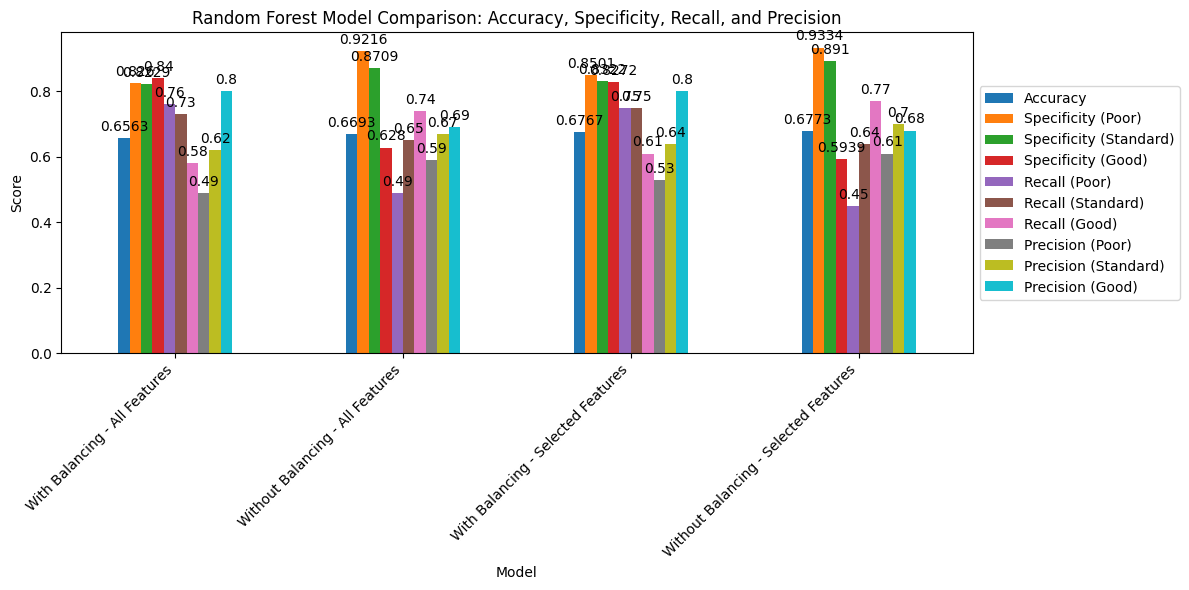

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated Comparison Data for Accuracy, Specificity, Recall, and Precision
accuracy_specificity_data = {
    'Model': ['With Balancing - All Features', 'Without Balancing - All Features',
              'With Balancing - Selected Features', 'Without Balancing - Selected Features'],
    'Accuracy': [0.6563, 0.6693, 0.6767, 0.6773],
    'Specificity (Poor)': [0.8260, 0.9216, 0.8501, 0.9334],
    'Specificity (Standard)': [0.8229, 0.8709, 0.8322, 0.8910],
    'Specificity (Good)': [0.8400, 0.6280, 0.8272, 0.5939],
    'Recall (Poor)': [0.76, 0.49, 0.75, 0.45],
    'Recall (Standard)': [0.73, 0.65, 0.75, 0.64],
    'Recall (Good)': [0.58, 0.74, 0.61, 0.77],
    'Precision (Poor)': [0.49, 0.59, 0.53, 0.61],
    'Precision (Standard)': [0.62, 0.67, 0.64, 0.70],
    'Precision (Good)': [0.80, 0.69, 0.80, 0.68]
}

# Create DataFrame for plotting
metrics_df = pd.DataFrame(accuracy_specificity_data)

# Plot the comparison for Accuracy, Specificity, Recall, and Precision
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 6))

# Add data labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

# Title and labels
plt.title('Random Forest Model Comparison: Accuracy, Specificity, Recall, and Precision')
plt.ylabel('Score')
plt.xlabel('Model')

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Move the legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


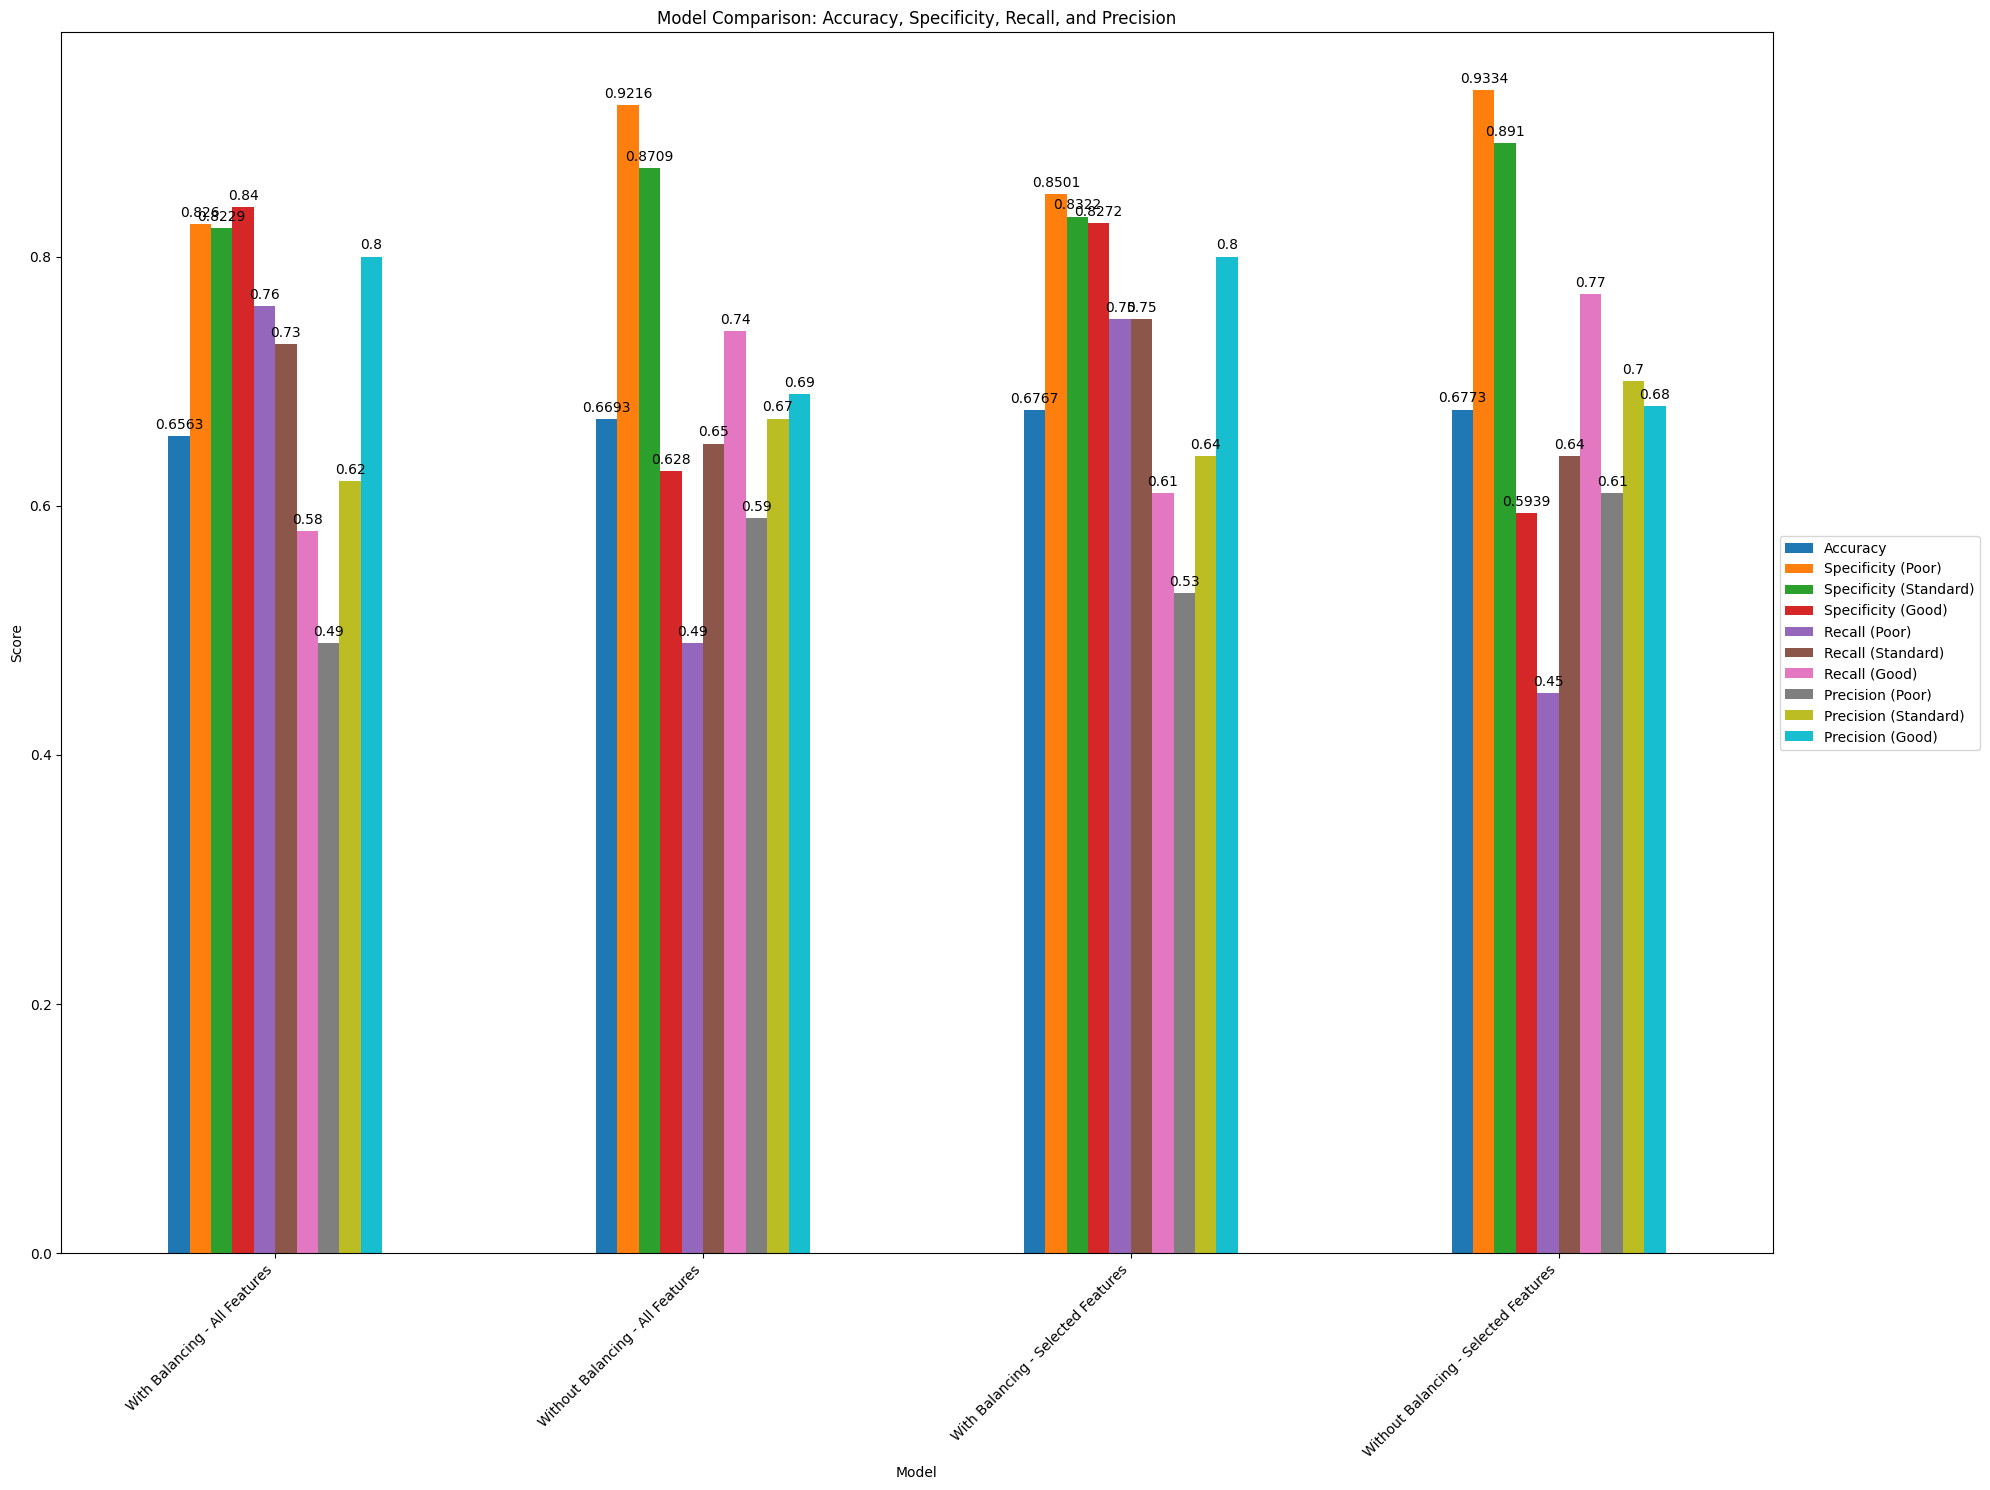

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Comparison Data for Accuracy, Specificity, Recall, and Precision
accuracy_specificity_data = {
    'Model': ['With Balancing - All Features', 'Without Balancing - All Features',
              'With Balancing - Selected Features', 'Without Balancing - Selected Features'],
    'Accuracy': [0.6563, 0.6693, 0.6767, 0.6773],
    'Specificity (Poor)': [0.8260, 0.9216, 0.8501, 0.9334],
    'Specificity (Standard)': [0.8229, 0.8709, 0.8322, 0.8910],
    'Specificity (Good)': [0.8400, 0.6280, 0.8272, 0.5939],
    'Recall (Poor)': [0.76, 0.49, 0.75, 0.45],
    'Recall (Standard)': [0.73, 0.65, 0.75, 0.64],
    'Recall (Good)': [0.58, 0.74, 0.61, 0.77],
    'Precision (Poor)': [0.49, 0.59, 0.53, 0.61],
    'Precision (Standard)': [0.62, 0.67, 0.64, 0.70],
    'Precision (Good)': [0.80, 0.69, 0.80, 0.68]
}

# Create DataFrame for plotting
metrics_df = pd.DataFrame(accuracy_specificity_data)

# Plot the comparison for Accuracy, Specificity, Recall, and Precision
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(20, 15))

# Add data labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

# Title and labels
plt.title('Model Comparison - RANDOM FORESTS: Accuracy, Specificity, Recall, and Precision')
plt.ylabel('Score')
plt.xlabel('Model')

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Move the legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()
